In [2]:
!pip install duckdb --no-index --find-links=file:///kaggle/input/birdclef24-duckdb-polars/kaggle/working/mysitepackages/duck_pkg

Looking in links: file:///kaggle/input/birdclef24-duckdb-polars/kaggle/working/mysitepackages/duck_pkg


In [3]:
!pip install polars[numpy,pandas,pyarrow] --no-index --find-links=file:///kaggle/input/birdclef24-duckdb-polars/kaggle/working/mysitepackages/polars_pkg

Looking in links: file:///kaggle/input/birdclef24-duckdb-polars/kaggle/working/mysitepackages/polars_pkg


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import duckdb as dd
import polars as pl
import os
import glob
import shutil
import zipfile
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
!pip install plotly
import plotly.express as px
import librosa
from IPython.display import Audio
import pickle
from joblib import dump, load
from pathlib import Path
!pip install -U imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

In [5]:
# Path to the directory containing your audio dataset
dataset_dir = '/kaggle/input/birdclef-2024/train_audio'
# Initialize an empty dictionary to store the mapping between audio files and labels
label_mapping = {}
# Iterate over subdirectories (classes) in the dataset directory
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    # Check if the item in the dataset directory is a directory
    if os.path.isdir(label_dir):
        # Iterate over audio files in the subdirectory (class)
        for audio_file in os.listdir(label_dir):
            # Add the mapping between audio file path and label to the dictionary
            audio_file_path = os.path.join(label_dir, audio_file)
            label_mapping[audio_file_path] = label
            
# label_mapping

# Create a list of tuples containing the audio file paths and labels
data = [(audio_file_path, label) for audio_file_path, label in label_mapping.items()]
# Create a Pandas DataFrame from the list of tuples
annotated_data = pd.DataFrame(data, columns=['audio_file_path', 'label'])

label_encoder = LabelEncoder()
annotated_data['encoded_label'] = label_encoder.fit_transform(annotated_data['label'])

annotated_data.head(10)

audio_file_path    label  encoded_label
0  /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1            137
1  /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1            137
2  /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1            137
3  /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1            137
4  /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1            137
5  /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1            137
6  /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1            137
7  /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1            137
8  /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1            137
9  /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1            137

In [6]:
def get_file_duration(full_file_path):
    duration = librosa.get_duration(path=full_file_path, sr=32000)
    return round(duration,2)

vect_func = np.vectorize(get_file_duration)

annotated_data['file_duration'] = vect_func(annotated_data['audio_file_path'])

In [30]:
dur_stats_per_species = dd.sql("select label, min(file_duration) as min_duration, max(file_duration) as max_duration \
, avg(file_duration) as avg_duration from annotated_data group by label")\
.pl().sort(by='avg_duration')

dur_stats_per_species_melted = dur_stats_per_species.melt(id_vars="label", value_vars=["min_duration","max_duration","avg_duration"])

In [9]:
fig0 = px.bar(dur_stats_per_species, x='avg_duration', y='label', orientation='h')
fig0.show()

In [31]:
fig_hist_files = px.histogram(dur_stats_per_species_melted, x="value", color="variable")
fig_hist_files.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [10]:
fig0 = px.bar(dur_stats_per_species.sort(by='min_duration'), x='min_duration', y='label', orientation='h')
fig0.show()

In [11]:
fig0 = px.bar(dur_stats_per_species.sort(by='max_duration'), x='max_duration', y='label', orientation='h')
fig0.show()

In [12]:
files_per_species = dd.sql("select label, count(distinct(audio_file_path)) as files from annotated_data group by label").pl().sort(by='files')

In [13]:
fig = px.bar(files_per_species, x='files', y='label', orientation='h')
fig.show()

In [27]:
fig_hist = px.histogram(files_per_species, x="files")
fig_hist.show()

In [21]:
file_w_max_dur = dd.sql("select ad.*, replace(ad.audio_file_path, '/kaggle/input/birdclef-2024/train_audio/', '') as file_name_w_label from annotated_data ad \
join (select label, max(file_duration) as max_duration from annotated_data group by label) agg \
on ad.label = agg.label and ad.file_duration = agg.max_duration order by ad.label\
").pl()

max_duration_files = file_w_max_dur.group_by("file_name_w_label").agg(pl.col("file_duration").max()).sort(by='file_duration')

In [25]:
max_duration_files.tail(15)

shape: (15, 2)
┌──────────────────────┬───────────────┐
│ file_name_w_label    ┆ file_duration │
│ ---                  ┆ ---           │
│ str                  ┆ f64           │
╞══════════════════════╪═══════════════╡
│ whiter2/XC265269.ogg ┆ 715.96        │
│ graher1/XC313107.ogg ┆ 718.42        │
│ rorpar/XC650130.ogg  ┆ 750.17        │
│ barswa/XC817803.ogg  ┆ 810.03        │
│ commoo3/XC349223.ogg ┆ 824.89        │
│ …                    ┆ …             │
│ greegr/XC558126.ogg  ┆ 1255.06       │
│ grewar3/XC806047.ogg ┆ 1955.52       │
│ houspa/XC790998.ogg  ┆ 2113.36       │
│ commyn/XC548866.ogg  ┆ 4486.54       │
│ blrwar1/XC826766.ogg ┆ 5964.23       │
└──────────────────────┴───────────────┘

In [26]:
fig2 = px.bar(max_duration_files.tail(15), x='file_duration', y='file_name_w_label', orientation='h')
fig2.show()

In [48]:
def audio_waveframe(file_path):
    # Load the audio file
    audio_data, sampling_rate = librosa.load(file_path)
    # Calculate the duration of the audio file
    duration = len(audio_data) / sampling_rate
    # Create a time array for plotting
    time = np.arange(0, duration, 1/sampling_rate)
    # Plot the waveform
    plt.figure(figsize=(30, 4))
    plt.plot(time, audio_data, color='blue')
    plt.title('Audio Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plot = plt.show()
    return plot

def spectrogram(file_path):
    # Compute the short-time Fourier transform (STFT)
    n_fft = 500  # Number of FFT points 2048
    hop_length = 50  # Hop length for STFT 512
    audio_data, sampling_rate = librosa.load(file_path)
    stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
    # Convert the magnitude spectrogram to decibels (log scale)
    spectrogram = librosa.amplitude_to_db(np.abs(stft))
    # Plot the spectrogram
    plt.figure(figsize=(30, 6))
    librosa.display.specshow(spectrogram, sr=sampling_rate, hop_length=hop_length, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plot = plt.show()
    return plot

def audio_analysis(file_path):
    aw = audio_waveframe(file_path)
    spg = spectrogram(file_path)
    return aw, spg

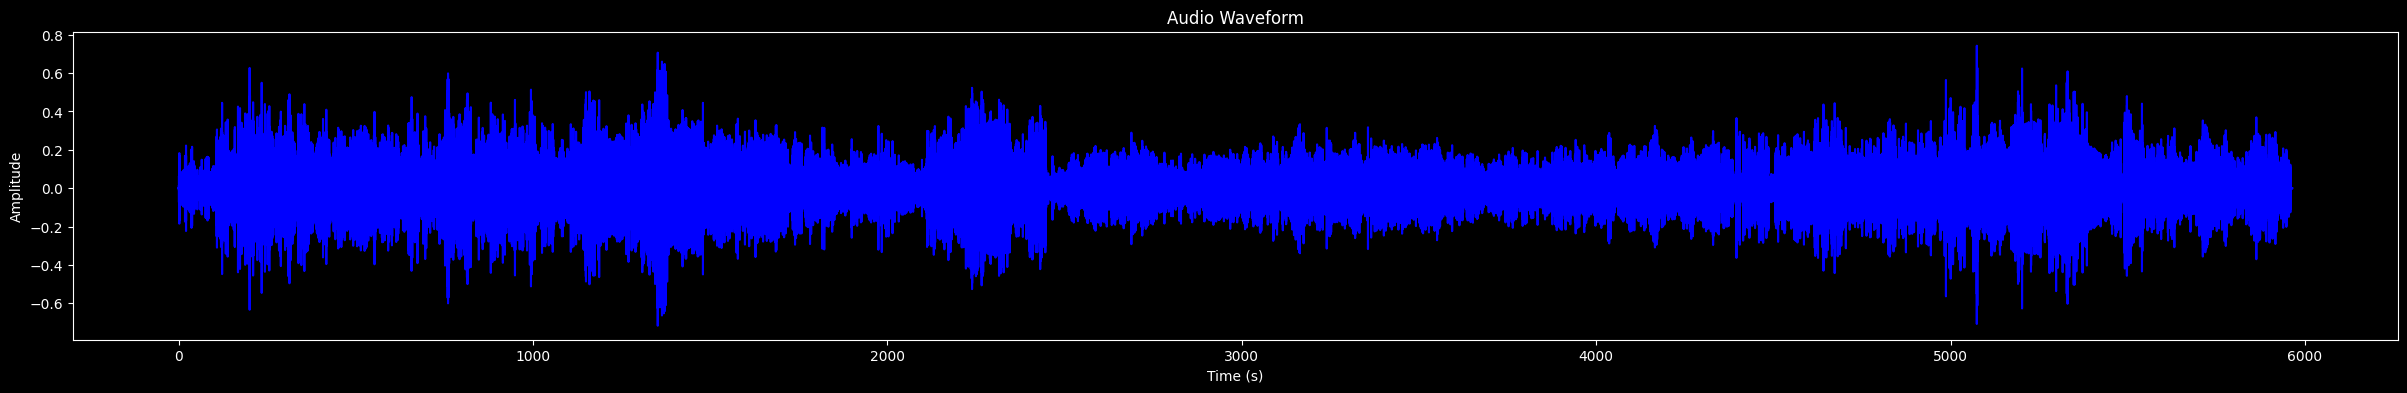

In [ ]:
audio_analysis(max_audio_file_path)
Audio(max_audio_file_path)

In [3]:
meta_data = pl.read_csv('/kaggle/input/birdclef-2024/train_metadata.csv', low_memory=True)
meta_data.head(5)

shape: (5, 12)
┌────────────┬────────────┬──────────┬──────────┬───┬────────────┬────────┬────────────┬───────────┐
│ primary_la ┆ secondary_ ┆ type     ┆ latitude ┆ … ┆ license    ┆ rating ┆ url        ┆ filename  │
│ bel        ┆ labels     ┆ ---      ┆ ---      ┆   ┆ ---        ┆ ---    ┆ ---        ┆ ---       │
│ ---        ┆ ---        ┆ str      ┆ f64      ┆   ┆ str        ┆ f64    ┆ str        ┆ str       │
│ str        ┆ str        ┆          ┆          ┆   ┆            ┆        ┆            ┆           │
╞════════════╪════════════╪══════════╪══════════╪═══╪════════════╪════════╪════════════╪═══════════╡
│ asbfly     ┆ []         ┆ ['call'] ┆ 39.2297  ┆ … ┆ Creative   ┆ 5.0    ┆ https://ww ┆ asbfly/XC │
│            ┆            ┆          ┆          ┆   ┆ Commons    ┆        ┆ w.xeno-can ┆ 134896.og │
│            ┆            ┆          ┆          ┆   ┆ Attributio ┆        ┆ to.org/134 ┆ g         │
│            ┆            ┆          ┆          ┆   ┆ n-Non…     ┆        ┆ 89…        ┆           │
│ asbfly     ┆ []         ┆ ['song'] ┆ 51.403   ┆ … ┆ Creative   ┆ 2.5    ┆ https://ww ┆ asbfly/XC │
│            ┆            ┆          ┆          ┆   ┆ Commons    ┆        ┆ w.xeno-can ┆ 164848.og │
│            ┆            ┆          ┆          ┆   ┆ Attributio ┆        ┆ to.org/164 ┆ g         │
│            ┆            ┆          ┆          ┆   ┆ n-Non…     ┆        ┆ 84…        ┆           │
│ asbfly     ┆ []         ┆ ['song'] ┆ 36.3319  ┆ … ┆ Creative   ┆ 2.5    ┆ https://ww ┆ asbfly/XC │
│            ┆            ┆          ┆          ┆   ┆ Commons    ┆        ┆ w.xeno-can ┆ 175797.og │
│            ┆            ┆          ┆          ┆   ┆ Attributio ┆        ┆ to.org/175 ┆ g         │
│            ┆            ┆          ┆          ┆   ┆ n-Non…     ┆        ┆ 79…        ┆           │
│ asbfly     ┆ []         ┆ ['call'] ┆ 21.1697  ┆ … ┆ Creative   ┆ 4.0    ┆ https://ww ┆ asbfly/XC │
│            ┆            ┆          ┆          ┆   ┆ Commons    ┆        ┆ w.xeno-can ┆ 207738.og │
│            ┆            ┆          ┆          ┆   ┆ Attributio ┆        ┆ to.org/207 ┆ g         │
│            ┆            ┆          ┆          ┆   ┆ n-Non…     ┆        ┆ 73…        ┆           │
│ asbfly     ┆ []         ┆ ['call'] ┆ 15.5442  ┆ … ┆ Creative   ┆ 4.0    ┆ https://ww ┆ asbfly/XC │
│            ┆            ┆          ┆          ┆   ┆ Commons    ┆        ┆ w.xeno-can ┆ 209218.og │
│            ┆            ┆          ┆          ┆   ┆ Attributio ┆        ┆ to.org/209 ┆ g         │
│            ┆            ┆          ┆          ┆   ┆ n-Non…     ┆        ┆ 21…        ┆           │
└────────────┴────────────┴──────────┴──────────┴───┴────────────┴────────┴────────────┴───────────┘

In [5]:
meta_data.describe()

shape: (9, 13)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬──────────┬───────────┬───────────┐
│ statistic ┆ primary_l ┆ secondary ┆ type      ┆ … ┆ license   ┆ rating   ┆ url       ┆ filename  │
│ ---       ┆ abel      ┆ _labels   ┆ ---       ┆   ┆ ---       ┆ ---      ┆ ---       ┆ ---       │
│ str       ┆ ---       ┆ ---       ┆ str       ┆   ┆ str       ┆ f64      ┆ str       ┆ str       │
│           ┆ str       ┆ str       ┆           ┆   ┆           ┆          ┆           ┆           │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪═══════════╪═══════════╡
│ count     ┆ 24459     ┆ 24459     ┆ 24459     ┆ … ┆ 24459     ┆ 24459.0  ┆ 24459     ┆ 24459     │
│ null_coun ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0.0      ┆ 0         ┆ 0         │
│ t         ┆           ┆           ┆           ┆   ┆           ┆          ┆           ┆           │
│ mean      ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ 3.843493 ┆ null      ┆ null      │
│ std       ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ 1.10084  ┆ null      ┆ null      │
│ min       ┆ asbfly    ┆ ['asbfly' ┆ ["'predat ┆ … ┆ Creative  ┆ 0.0      ┆ http://xe ┆ asbfly/XC │
│           ┆           ┆ ]         ┆ or scoldi ┆   ┆ Commons   ┆          ┆ no-canto. ┆ 134896.og │
│           ┆           ┆           ┆ ng'"]     ┆   ┆ Attributi ┆          ┆ org/66723 ┆ g         │
│           ┆           ┆           ┆           ┆   ┆ on-Non…   ┆          ┆ 9         ┆           │
│ 25%       ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ 3.0      ┆ null      ┆ null      │
│ 50%       ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ 4.0      ┆ null      ┆ null      │
│ 75%       ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ 5.0      ┆ null      ┆ null      │
│ max       ┆ zitcis1   ┆ []        ┆ ['wings   ┆ … ┆ Creative  ┆ 5.0      ┆ https://x ┆ zitcis1/X │
│           ┆           ┆           ┆ flapping  ┆   ┆ Commons   ┆          ┆ eno-canto ┆ C858550.o │
│           ┆           ┆           ┆ sound']   ┆   ┆ Attributi ┆          ┆ .org/8593 ┆ gg        │
│           ┆           ┆           ┆           ┆   ┆ on-Sha…   ┆          ┆ 16        ┆           │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴──────────┴───────────┴───────────┘

In [6]:
fig = px.scatter_mapbox(meta_data, lat='latitude', lon='longitude', color='common_name', 
                        hover_name='common_name', hover_data=['latitude', 'longitude'], 
                        title='Origin of Bird Species',
                        zoom=1, height=600, template='plotly_dark')
fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
      ])
fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [28]:
meta_data.filter((pl.col('primary_label')=='redspu1') & (pl.col('filename')=='redspu1/XC325427.ogg'))\
.select('type','latitude','longitude','common_name','rating')

shape: (1, 5)
┌──────────────────────────┬──────────┬───────────┬──────────────┬────────┐
│ type                     ┆ latitude ┆ longitude ┆ common_name  ┆ rating │
│ ---                      ┆ ---      ┆ ---       ┆ ---          ┆ ---    │
│ str                      ┆ f64      ┆ f64       ┆ str          ┆ f64    │
╞══════════════════════════╪══════════╪═══════════╪══════════════╪════════╡
│ ['call', 'male', 'song'] ┆ 15.8657  ┆ 74.0592   ┆ Red Spurfowl ┆ 4.0    │
└──────────────────────────┴──────────┴───────────┴──────────────┴────────┘

#### Possibility of a feature with the type of recording, latitude & longitude
#### the rating can be used as a weight

In [29]:
meta_data.filter((pl.col('primary_label')=='redspu1') & (pl.col('filename')=='redspu1/XC325427.ogg')).select('type')

shape: (1, 1)
┌──────────────────────────┐
│ type                     │
│ ---                      │
│ str                      │
╞══════════════════════════╡
│ ['call', 'male', 'song'] │
└──────────────────────────┘

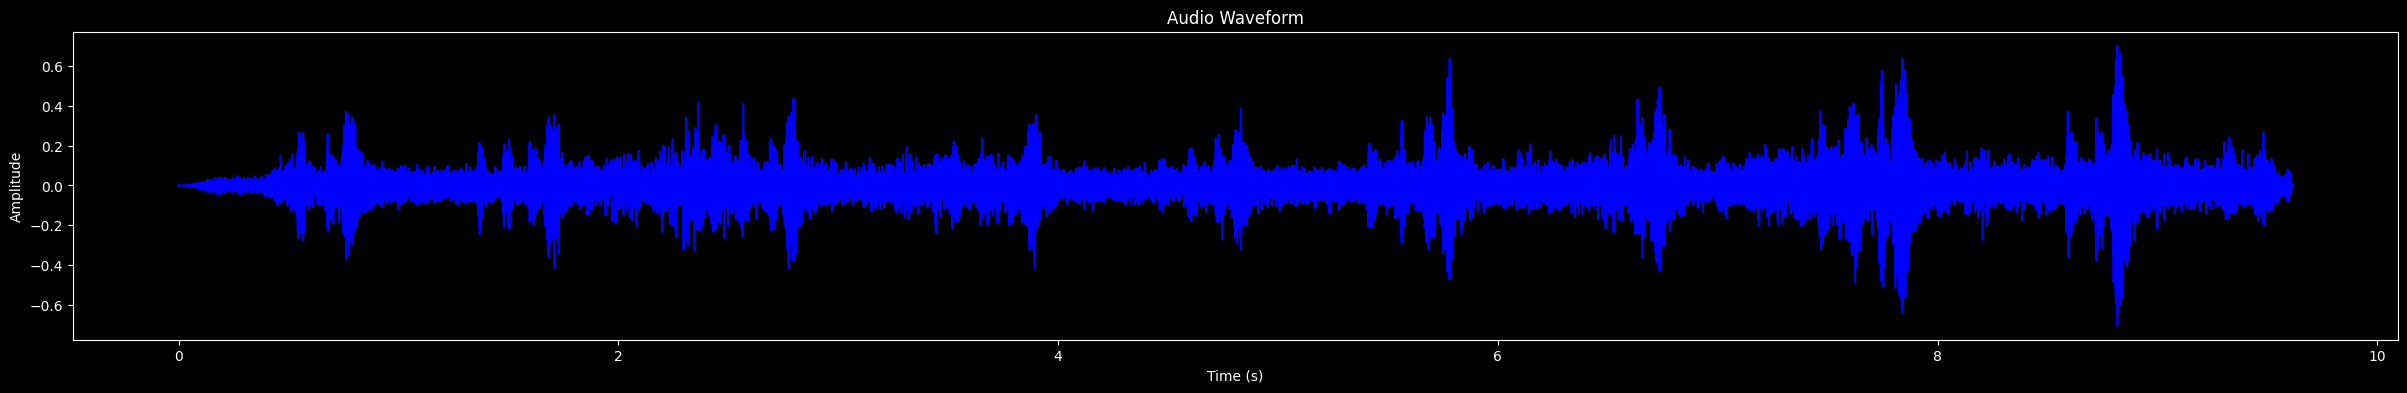

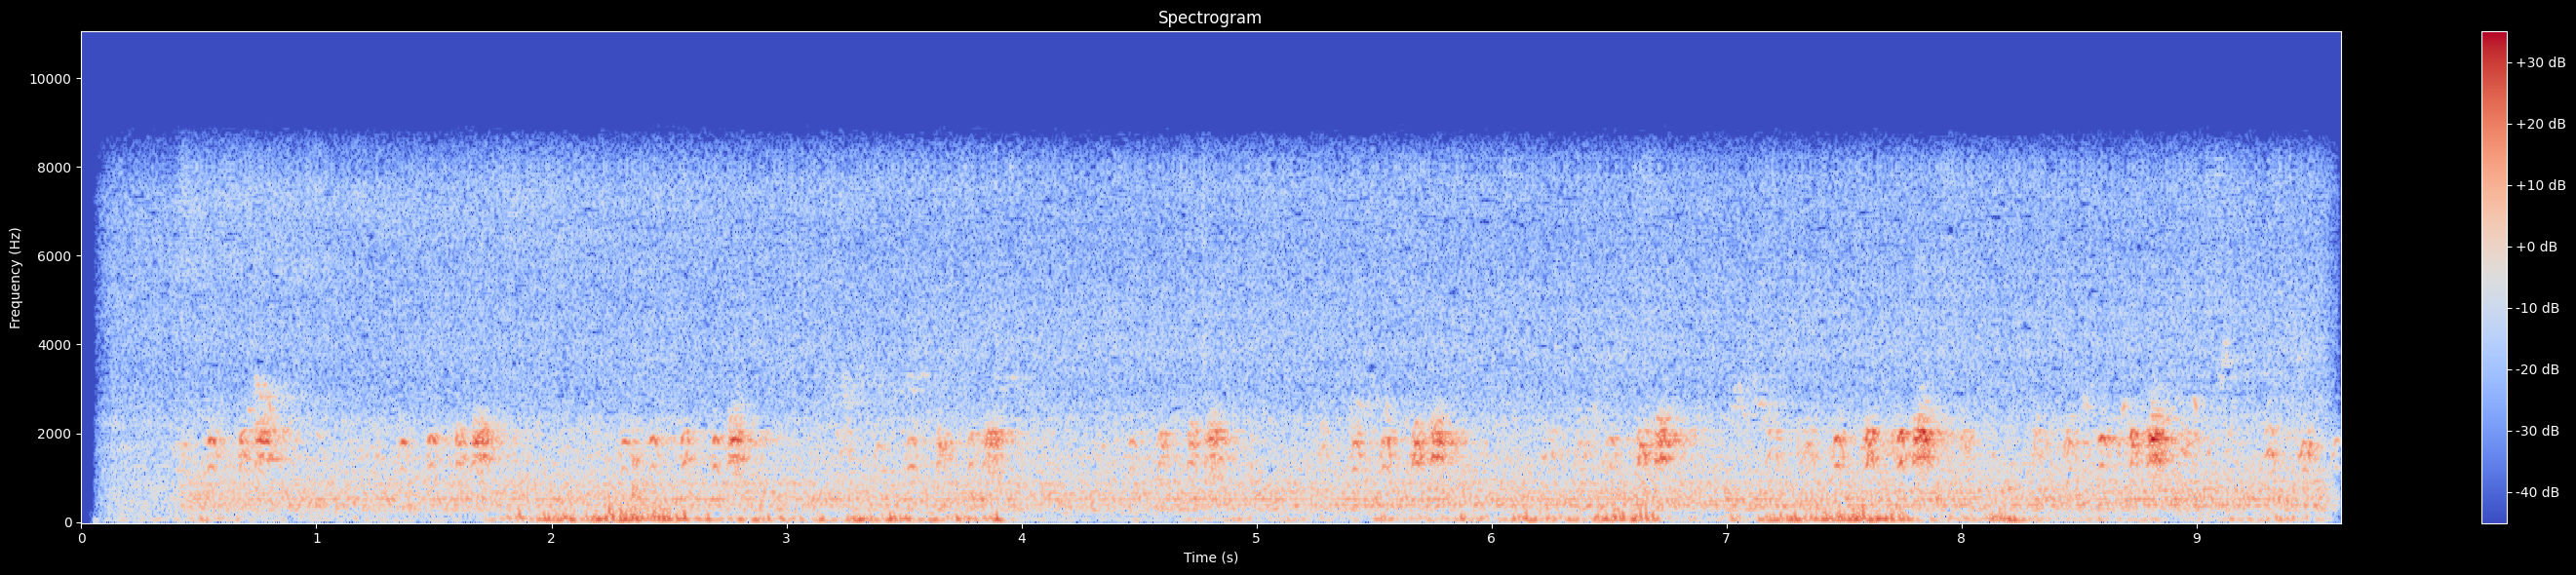

In [22]:
audio_data, sampling_rate = librosa.load('/kaggle/input/birdclef-2024/train_audio/redspu1/XC325427.ogg')
print(sampling_rate)

22050


In [23]:
duration = librosa.get_duration(y=audio_data, sr=sampling_rate)
duration

9.613015873015874

audio_file_path    label  encoded_label
0  /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1            137
1  /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1            137
2  /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1            137
3  /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1            137
4  /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1            137
5  /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1            137
6  /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1            137
7  /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1            137
8  /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1            137
9  /kaggle/input/birdclef-2024/train_audio/redspu...  redspu1            137

In [31]:
print(annotated_data['audio_file_path'].iloc[10])
print(annotated_data['label'].iloc[10])

/kaggle/input/birdclef-2024/train_audio/redspu1/XC325427.ogg
redspu1


In [21]:
annotated_data.shape[0]

24459

In [38]:
# Function to extract features from audio file
def extract_features(file_path):
    # Load audio file
    audio, sample_rate = librosa.load(file_path)
    # Extract features using Mel-Frequency Cepstral Coefficients (MFCC)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    # Flatten the features into a 1D array
    flattened_features = np.mean(mfccs.T, axis=0)
    return flattened_features

In [39]:
def load_data_and_extract_features():
    labels = []
    features = []
    # Loop through each audio file in the dataset directory
    for i in range(annotated_data.shape[0]):
        labels.append(annotated_data['label'].iloc[i])
        features.append(extract_features(annotated_data['audio_file_path'].iloc[i]))
    
    return np.array(features), np.array(labels)

In [34]:
extracted_training_features, labels = load_data_and_extract_features()

# for i in tqdm(annotated_data['audio_file_path']):
#     features = extract_features(file_path=i)
#     # print(features)
#     extracted_features.append(features)

In [35]:
with open("extracted_features", "wb") as file:   #Pickling
    pickle.dump(extracted_training_features, file)

In [2]:
with open("/kaggle/input/extracted-features-pickle/extracted_features", "rb") as file:
    pickled_extracted_features = pickle.load(file)

In [4]:
x = np.vstack(pickled_extracted_features)
y = annotated_data['encoded_label']

print(x.shape)
print(y.shape)

(24459, 40)
(24459,)


In [8]:
ros = RandomOverSampler(random_state=42)
features_resampled, labels_resampled = ros.fit_resample(x, y)

print(features_resampled.shape)
print(labels_resampled.shape)

(91000, 40)
(91000,)


In [23]:
unique_labels = labels_resampled.unique().sort()

In [10]:
x_train, x_test, y_train, y_test = train_test_split(features_resampled, labels_resampled, test_size=0.2, random_state=42)

In [11]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model = random_forest_classifier.fit(x_train, y_train)
y_predict = random_forest_model.predict(x_test)

In [13]:
accuracy = accuracy_score(y_test, y_predict)
print("Accuracy:", accuracy)

Accuracy: 0.8725274725274725


In [12]:
y_predict_proba = random_forest_model.predict_proba(x_test)

In [24]:
roc_score = roc_auc_score(y_test, y_predict_proba, multi_class='ovo', average='macro', labels=unique_labels)
print("ROC AUC Score:", roc_score)

ROC AUC Score: 0.983499125054007


In [25]:
def evaluate_model(y_true, y_pred):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    # Calculate precision
    precision = precision_score(y_true, y_pred, average='weighted')
    # Calculate recall
    recall = recall_score(y_true, y_pred, average='weighted')
    # Calculate F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1

# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(y_test, y_predict)
# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8725274725274725
Precision: 0.8603642625219577
Recall: 0.8725274725274725
F1 Score: 0.8646534972589429


In [26]:
dump(random_forest_model, 'audio_classifier_model.joblib')

['audio_classifier_model.joblib']

In [40]:
def audio_classification(file_path):
    audio = file_path
    print(audio)
    extracted_features = extract_features(audio).reshape(1, -1)
    y_predict = random_forest_model.predict(extracted_features)
    labels_list = annotated_data['label'].unique()
    encoded_label = annotated_data['encoded_label'].unique()

    labels = {}
    for label, prediction in zip(encoded_label, labels_list):
        labels[label] = prediction
    if y_predict[0] in labels.keys():
        predicted = ('Predicted Class:', labels[y_predict[0]])
    return predicted

In [46]:
extracted_features = extract_features('/kaggle/input/birdclef-2024/unlabeled_soundscapes/1002849488.ogg').reshape(1, -1)
y_predict_proba = random_forest_model.predict_proba(extracted_features)
y_predict = random_forest_model.predict(extracted_features)

In [55]:
labels_list = annotated_data['label'].unique()
encoded_label = annotated_data['encoded_label'].unique()

In [60]:
labels = {}
for label, prediction in zip(encoded_label, labels_list):
    labels[label] = prediction
    
labels.keys()

dict_keys([137, 181, 115, 141, 69, 90, 41, 100, 180, 176, 23, 26, 11, 76, 62, 28, 132, 13, 56, 73, 45, 124, 24, 67, 173, 17, 92, 74, 71, 168, 157, 65, 166, 44, 140, 35, 79, 77, 59, 52, 138, 72, 93, 29, 116, 53, 133, 102, 99, 96, 148, 122, 82, 110, 178, 55, 42, 155, 120, 139, 7, 16, 174, 108, 109, 147, 144, 8, 146, 89, 111, 107, 75, 105, 143, 60, 39, 121, 153, 179, 129, 158, 18, 43, 1, 51, 88, 142, 94, 83, 81, 0, 171, 163, 54, 4, 10, 177, 78, 162, 150, 20, 19, 85, 149, 80, 103, 123, 37, 98, 25, 91, 169, 131, 118, 114, 50, 154, 57, 46, 49, 160, 130, 70, 6, 128, 87, 58, 95, 40, 47, 38, 167, 125, 68, 27, 104, 175, 156, 15, 2, 159, 34, 66, 63, 161, 97, 22, 3, 170, 172, 119, 113, 32, 5, 21, 61, 164, 112, 145, 127, 86, 135, 134, 48, 12, 64, 126, 30, 31, 101, 165, 136, 117, 151, 36, 9, 33, 152, 84, 14, 106])

In [61]:
labels[y_predict[0]]

'grefla1'

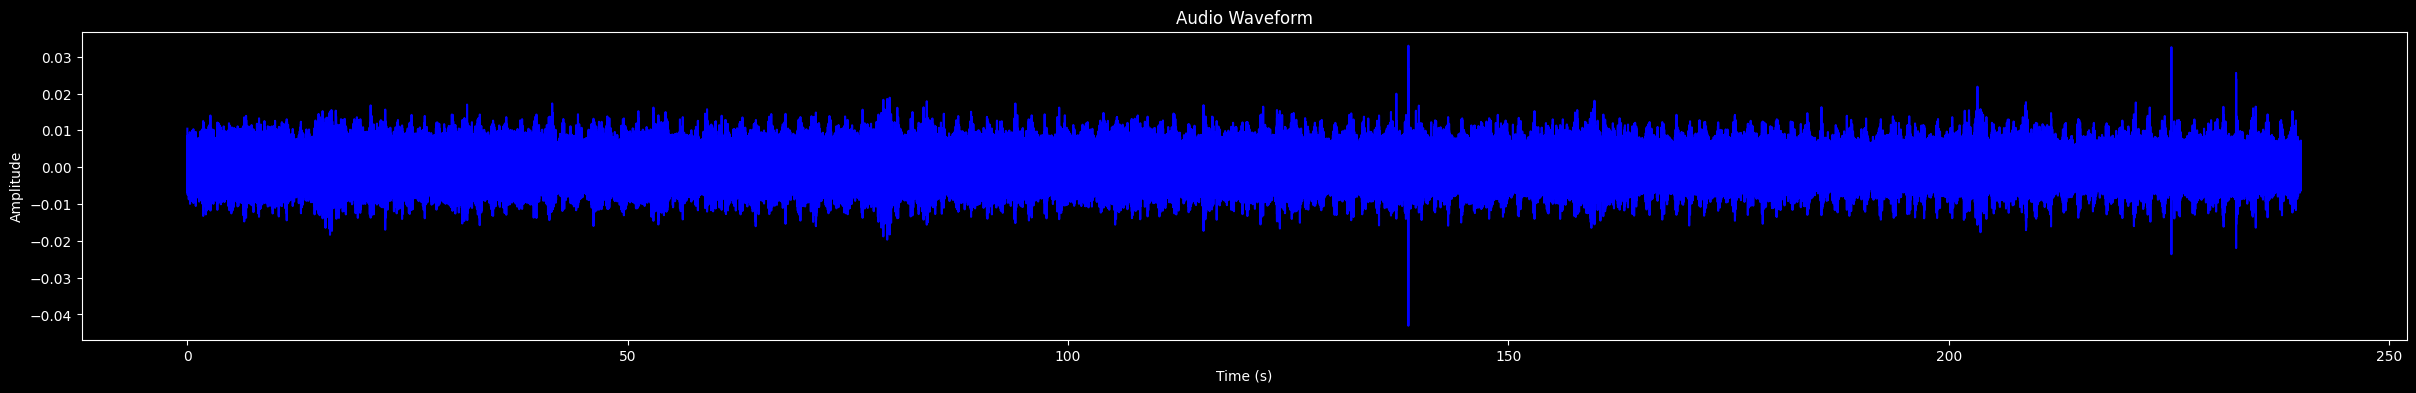

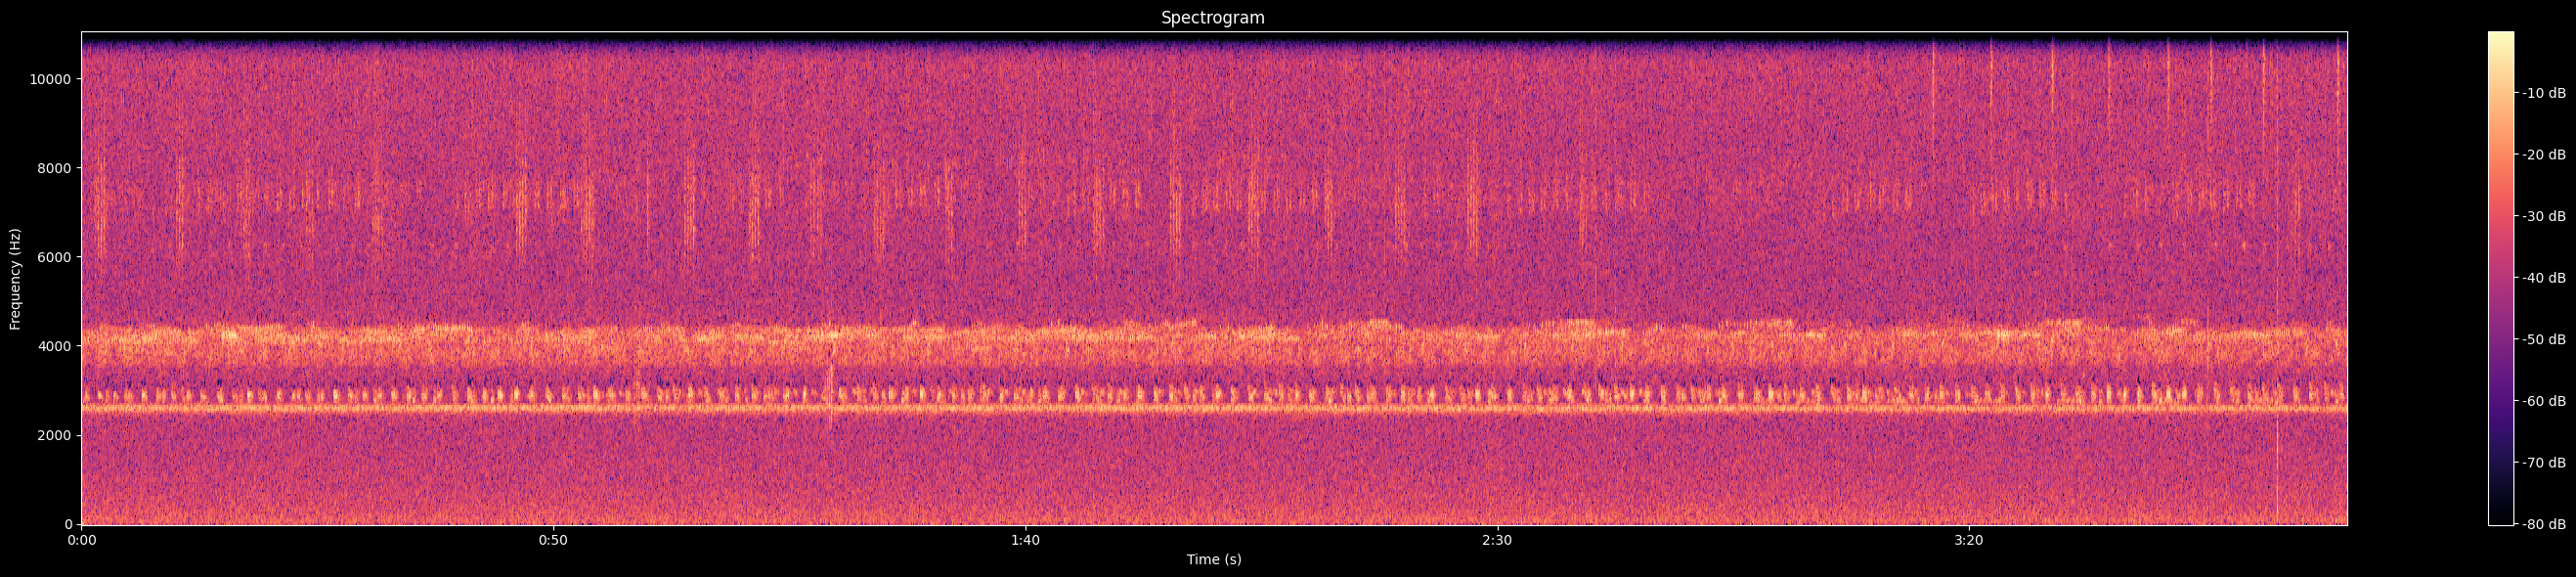

In [42]:
file_path = '/kaggle/input/birdclef-2024/unlabeled_soundscapes/1002849488.ogg'
audio_analysis(file_path)
Audio(file_path)

In [43]:
audio_classification(file_path)

/kaggle/input/birdclef-2024/unlabeled_soundscapes/1002849488.ogg


('Predicted Class:', 'grefla1')

In [ ]:
sample_submission = pl.read_csv('/kaggle/input/birdclef-2024/sample_submission.csv', low_memory=True)
print(sample_submission.shape)
sample_submission.head(10)

In [ ]:
sample_submission2 = sample_submission.drop("row_id")
sample_submission2.sum_horizontal()

In [ ]:
print(np.array(sample_submission2)[2].shape)
print(np.array(sample_submission2).shape)

In [ ]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True, as_frame=False)
print(X.shape)
print(type(y))
print(X.shape)
print(y.shape)
print(X[2])
print(y[2])
print(y[[10, 25, 50]])

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver="liblinear").fit(X, y)
print(clf.predict_proba(X).shape)
print(clf.predict_proba(X)[4].shape)

In [ ]:
sample_labels = [i for i in range(0, 182, 1)]
len(sample_labels)

In [ ]:
y_true_sample = np.array([0,1,2])
roc_auc_score(y_true_sample, sample_submission2, multi_class='ovo', average='macro', labels=sample_labels)

In [ ]:
roc_auc_score(y_true_sample, sample_submission2, multi_class='ovr', average='micro', labels=sample_labels)